/var/folders/bf/t7zr8nds6f727x199sygjpbh0000gn/T/ipykernel_34105/2860457541.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Created'] = pd.to_datetime(df['Created'])


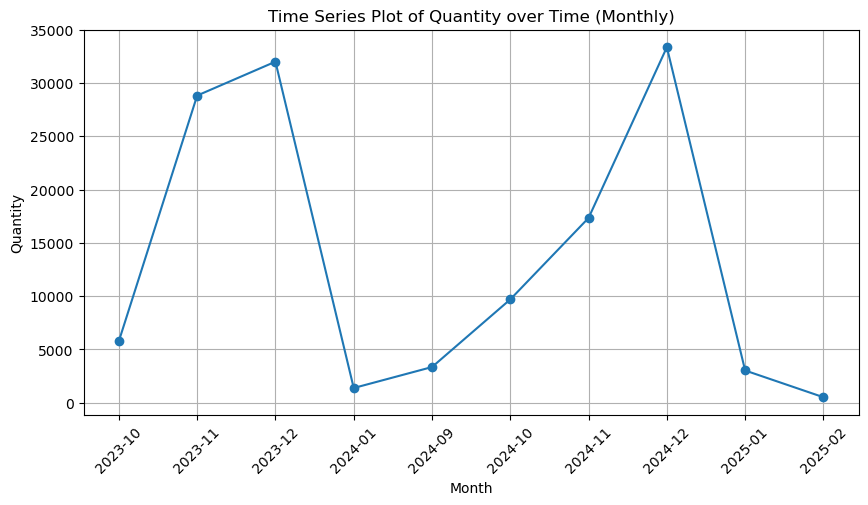

Average Model Performance (Overall metrics):
               Model   Average MSE  Average RMSE   Average MAE  Average R²  \
0  Linear Regression  1.457496e+08  11266.523676  10656.050604 -147.546451   
1              Ridge  1.394060e+08  10933.099148  10376.193906 -144.821180   
2              Lasso  1.457157e+08  11264.457688  10654.182105 -147.533247   
3        Elastic Net  1.342000e+08  10622.421782  10111.454923 -143.812562   
4                SVR  2.475018e+08  13294.599098  12637.199917 -357.768927   
5      Decision Tree  6.334988e+07   7546.735711   6428.400000  -60.857664   
6      Random Forest  5.826281e+07   6977.359670   6102.312000  -57.792143   
7  Gradient Boosting  6.605009e+07   7702.052906   6542.508226  -60.876531   
8            XGBoost  6.287080e+07   7214.246311   6092.898999  -59.090734   
9           CatBoost  6.830605e+07   7903.399472   6879.721675  -62.580215   

   RMSE Std Dev  
0   4337.635461  
1   4457.951204  
2   4339.087700  
3   4622.138815  
4   84

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

# Function to load and prepare data based on aggregation type
def load_and_prepare_data(filepath, aggregation_type='Monthly'):
    df = pd.read_csv(filepath)
    df.drop(columns=['Sku'], inplace=True)  # Drop SKU column if not needed for prediction
    df['Created'] = pd.to_datetime(df['Created'])

    if aggregation_type == 'Monthly':
        # Aggregating by Month
        df['YearMonth'] = df['Created'].dt.to_period('M')  # Create a period for year-month
        aggregated_data = df.groupby('YearMonth')['Quantity'].sum().reset_index()  # Sum the quantities for each month
        aggregated_data['Month'] = aggregated_data['YearMonth'].dt.month  # Extract month
        aggregated_data['Year'] = aggregated_data['YearMonth'].dt.year  # Extract year

    elif aggregation_type == 'Weekly':
        # Aggregating by Week
        df['YearWeek'] = df['Created'].dt.to_period('W')  # Convert to a period with weekly frequency
        aggregated_data = df.groupby('YearWeek')['Quantity'].sum().reset_index()  # Sum the quantities for each week
        aggregated_data['Week'] = aggregated_data['YearWeek'].dt.week  # Extract week number
        aggregated_data['Year'] = aggregated_data['YearWeek'].dt.year  # Extract year

    elif aggregation_type == 'Daily':
        # Aggregating by Day
        df['Day'] = df['Created'].dt.date  # Extract date for daily aggregation
        aggregated_data = df.groupby('Day')['Quantity'].sum().reset_index()  # Sum the quantities for each day
        aggregated_data['Year'] = pd.to_datetime(aggregated_data['Day']).dt.year  # Extract year from date

    elif aggregation_type == 'Quarterly':
        # Aggregating by Quarter
        df['Quarter'] = df['Created'].dt.to_period('Q')  # Create a period for year-quarter (e.g., '2024Q1')
        aggregated_data = df.groupby('Quarter')['Quantity'].sum().reset_index()  # Sum the quantities for each quarter
        aggregated_data['Year'] = aggregated_data['Quarter'].dt.year  # Extract year from quarter
        aggregated_data['Quarter'] = aggregated_data['Quarter'].dt.quarter  # Extract the quarter number

    elif aggregation_type == 'Yearly':
        # Aggregating by Year
        df['Year'] = df['Created'].dt.year  # Extract year for yearly aggregation
        aggregated_data = df.groupby('Year')['Quantity'].sum().reset_index()  # Sum the quantities for each year

    return aggregated_data

# Function to plot the time series data
def plot_timeseries(data, aggregation_type):
    plt.figure(figsize=(10, 5))
    if aggregation_type == 'Monthly':
        plt.plot(data['YearMonth'].astype(str), data['Quantity'], marker='o', linestyle='-')
        plt.title('Time Series Plot of Quantity over Time (Monthly)')
        plt.xlabel('Month')
    elif aggregation_type == 'Weekly':
        plt.plot(data['YearWeek'].astype(str), data['Quantity'], marker='o', linestyle='-')
        plt.title('Time Series Plot of Quantity over Time (Weekly)')
        plt.xlabel('Week')
    elif aggregation_type == 'Daily':
        plt.plot(data['Day'].astype(str), data['Quantity'], marker='o', linestyle='-')
        plt.title('Time Series Plot of Quantity over Time (Daily)')
        plt.xlabel('Day')
    elif aggregation_type == 'Quarterly':
        plt.plot(data['Quarter'].astype(str), data['Quantity'], marker='o', linestyle='-')
        plt.title('Time Series Plot of Quantity over Time (Quarterly)')
        plt.xlabel('Quarter')
    elif aggregation_type == 'Yearly':
        plt.plot(data['Year'], data['Quantity'], marker='o', linestyle='-')
        plt.title('Time Series Plot of Quantity over Time (Yearly)')
        plt.xlabel('Year')

    plt.ylabel('Quantity')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()  # Show the plot

# Function to perform cross-validation and evaluate models
def cross_validate_models(data, aggregation_type):
    if aggregation_type == 'Monthly':
        X = data[['Month', 'Year']]  # Using 'Month' and 'Year' as features for monthly data
    elif aggregation_type == 'Weekly':
        X = data[['Week', 'Year']]  # Using 'Week' and 'Year' as features for weekly data
    elif aggregation_type == 'Daily':
        X = data[['Year', 'Day']]  # Using 'Year' and 'Day' as features for daily data
    elif aggregation_type == 'Quarterly':
        X = data[['Quarter', 'Year']]  # Using 'Quarter' and 'Year' as features for quarterly data
    elif aggregation_type == 'Yearly':
        X = data[['Year']]  # Using 'Year' as features for yearly data

    y = data['Quantity']

    # Ensure that X and y have the same number of rows
    assert len(X) == len(y), f"Mismatch in number of samples: X({len(X)}) vs y({len(y)})"

    # Cross-validation with 20% test size using KFold (5 splits for 20% test data)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Models list without GridSearch for simplicity
    models = [
        ('Linear Regression', LinearRegression()),
        ('Ridge', Ridge()),
        ('Lasso', Lasso()),
        ('Elastic Net', ElasticNet()),
        ('SVR', SVR()),
        ('Decision Tree', DecisionTreeRegressor()),
        ('Random Forest', RandomForestRegressor()),
        ('Gradient Boosting', GradientBoostingRegressor()),
        ('XGBoost', xgb.XGBRegressor(objective='reg:squarederror')),
        ('CatBoost', CatBoostRegressor(verbose=0))
    ]

    results = {}
    cross_val_results = {}

    # Cross-validation loop to calculate the metrics
    for name, model in models:
        mse_list, rmse_list, mae_list, r2_list, rmse_std = [], [], [], [], []

        for fold_idx, (train_index, test_index) in enumerate(kf.split(X), start=1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Fit the model
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)

            # Calculate metrics for each fold
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)

            # Append metrics for each fold
            mse_list.append(mse)
            rmse_list.append(rmse)
            mae_list.append(mae)
            r2_list.append(r2)

        # Calculate average metrics across all folds
        avg_mse = np.mean(mse_list)
        avg_rmse = np.mean(rmse_list)
        avg_mae = np.mean(mae_list)
        avg_r2 = np.mean(r2_list)
        rmse_std_dev = np.std(rmse_list)  # Standard deviation of RMSE across folds

        # Store the average metrics for the model in the main results table
        results[name] = {
            'Average MSE': avg_mse,
            'Average RMSE': avg_rmse,
            'Average MAE': avg_mae,
            'Average R²': avg_r2,
            'RMSE Std Dev': rmse_std_dev
        }

        # Store RMSE for cross-validation results table
        cross_val_results[name] = rmse_list

    # Convert the results dictionary to a DataFrame for overall results
    results_df = pd.DataFrame(results).T
    results_df.index.name = 'Model'
    results_df.reset_index(inplace=True)

    # Convert the cross-validation fold results to a DataFrame
    cross_val_df = pd.DataFrame(cross_val_results)

    return results_df, cross_val_df

# Example usage
filepath = 'data/SKU2/0043121-X_2.csv'  # Replace with your actual file path
aggregation_type = 'Monthly'  # Use either 'Daily', 'Weekly', 'Monthly', 'Quarterly', or 'Yearly'

# Load and prepare data
data = load_and_prepare_data(filepath, aggregation_type)

# Plot time series data
plot_timeseries(data, aggregation_type)

# Perform cross-validation and evaluate models
results, cross_val_results = cross_validate_models(data, aggregation_type)

# Display the results
print("Average Model Performance (Overall metrics):")
print(results)

# Display cross-validation results (RMSE for each fold)
print("\nCross-Validation Results (RMSE for each fold):")
print(cross_val_results)